# NPZD model with seasonality

### NPZD (Nutrient-Phytoplankton-Zooplankton-Detritus) model, modified from Sarmiento and Gruber (2006)

    - dN/dt = -Vmax*I/(I+KI)*N/(N+K)*P - ent*(N-Nth) + ld*D
    - dP/dt = Vmax*I/(I+KI)*N/(N+K)*P -g*P*Z/Kp - (lp+ent)*P
    - dZ/dt = a*g*P*Z/Kp - (lz+ent)*Z
    - dD/dt = lp*P + Z*( (1-a)*g*P/Kp+lz ) - (ld+ent)*D - Wsink/hml*D
    
    - Seasonal MLD = h0 + h1*( 1+cos(2*pi/360*t) )
    - Entrainment = 1/h*dhdt (if dhdt > 0) + c
    - Seasonal light = Io(t) = fPAR*( I0 + I1*( 1+cos(2*pi/360*t) ) )W/m2
    - Average ML light = Io(t)*zI/hml(t)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
# coefficients
h = 1 # timestep size
t = np.arange(0,360,h) # time in day
N = np.size(t) # dimension of time step
nuto = .001 # initial condition for nutrient
phyo = .001 # initial condition for phyto
zooo = .001 # initial condition for zoo
deto = .001 # initial condition for detritus
# set parameters
Vmax = 1.0 # per day
K = 2 # mmol/m3
Kp= 2.8 # mmol/m3
Kammo=0.2
a = 0.7
b= 0.3
g = 1.4 # per day
lp = 0.05 # per day
lz = 0.12 # per day
ld = 0.05 # per day
Wsink=10 # m/day
c = .01 # 1/day, background mixing rate
#
h0 = 50 # m
h1 = 100 # m
#
I0 = 20 # W/m2
I1 = 150 # W/m2
#
zI = 20 #m
KI = 80 # W/m2
#
fPAR = .4

# Absolute value for 15N, 14N in deep water
Nth15 = 1.005 # d15NO3 = 5
Nth14 = 1
ammoth15= 1.012 # d15NH4 = 12
ammoth14 = 1

# Nitrification rate
nit = 0.15 

# Epsiolon for biological processes
eps_uptakeN= -5 # Phytoplankton NO3 uptake
eps_uptakeA= -10 # Phytoplankton NH4 uptake
eps_egestion= -1 # Zooplankton egestion
eps_excretion= -1 # Zooplankton excretion
eps_reminer= -1 # Remineralization
eps_nitri= -14 # Nitrification

In [4]:
#def R(d):
#    r=(d/1000+1)*0.00366
#    return r

# Calulate alpha from epsilon
def alpha(eps):
    alpha = np.exp(eps/1000)
    return alpha

#def delta(r):
#    d = ((r/0.00366)-1)*1000
#    return d


In [5]:
# define model_run function
def model_run(trange,xinit,param,dt,tendency):
    # expand input
    Vmax = param[0]
    K = param[1]
    Kp= param[2]
    a = param[3]
    g = param[4]
    lp = param[5]
    lz = param[6]
    ld= param[7]
    KI = param[8]
    Nth = param[9]
    zI = param[10]
    Wsink=param[11]
    c = param[12]
    sol = solve_ivp(tendency,trange,xinit,args=(Vmax,K,Kp,a,g,lp,lz,ld,KI,Nth,zI,Wsink,c),method='RK45',max_step=dt)
    return sol

In [16]:
### NPZD
def cal_N15(t,x,Vmax,K,Kp,a,g,lp,lz,ld,KI,Nth,zI,Wsink,c):
    nitro, phy, zoo, det, N15, P15, Z15, D15 = x
    hml = h0+h1*(1+np.cos(2*np.pi/360*t))
    dhdt= -h1*(2*np.pi/360)*np.sin(2*np.pi/360*t)
    ent0=dhdt/hml
    ent=np.where(ent0>0,ent0,0) + c
    I=fPAR*(I0+I1*(1-np.cos(2*np.pi/360*t)))
    Iave=I*zI/hml
    dnitrodt = -Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI) -ent*(nitro-Nth) + ld*det + (a-b)*zoo*g*phy/Kp
    dphydt = Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI) - zoo*g*phy/Kp - (lp+ent)*phy
    dzoodt = zoo*g*phy/Kp - (lz+ent)*zoo - (a-b)*zoo*g*phy/Kp - (1-a)*zoo*g*phy/Kp
    ddetdt = (1-a)*zoo*g*phy/Kp + lz*zoo + lp*phy - (ld+ent)*det -Wsink/hml*det
    d15nitrodt = -Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI)*N15*alpha(eps_uptakeN) - ent*(nitro*N15-Nth*Nth15) + ld*det*D15*alpha(eps_reminer) + (a-b)*zoo*g*phy/Kp*Z15
    d15phydt = Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI)*N15*alpha(eps_uptakeN) - zoo*g*phy/Kp*P15 - (lp+ent)*phy*P15
    d15zoodt = zoo*g*phy/Kp*P15 - (lz+ent)*zoo*Z15 - (a-b)*zoo*g*phy/Kp*Z15*alpha(eps_excretion) - (1-a)*zoo*g*phy/Kp*Z15*alpha(eps_egestion)
    d15detdt = (1-a)*zoo*g*phy/Kp*Z15*alpha(eps_egestion) + lz*zoo*Z15 + lp*phy*P15 - ld*det*D15*alpha(eps_reminer) -ent*det*D15 -Wsink/hml*det*D15
    out=np.array([dnitrodt,dphydt,dzoodt,ddetdt,d15nitrodt,d15phydt,d15zoodt,d15detdt])
    return out

def cal_N14(t,x,Vmax,K,Kp,a,g,lp,lz,ld,KI,Nth,zI,Wsink,c):
    nitro, phy, zoo, det, N14, P14, Z14, D14 = x
    hml = h0+h1*(1+np.cos(2*np.pi/360*t))
    dhdt= -h1*(2*np.pi/360)*np.sin(2*np.pi/360*t)
    ent0=dhdt/hml
    ent=np.where(ent0>0,ent0,0) + c
    I=fPAR*(I0+I1*(1-np.cos(2*np.pi/360*t)))
    Iave=I*zI/hml
    dnitrodt = -Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI) -ent*(nitro-Nth) + ld*det + (a-b)*zoo*g*phy/Kp
    dphydt = Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI) - zoo*g*phy/Kp - (lp+ent)*phy
    dzoodt = zoo*g*phy/Kp - (lz+ent)*zoo - (a-b)*zoo*g*phy/Kp - (1-a)*zoo*g*phy/Kp
    ddetdt = (1-a)*zoo*g*phy/Kp + lz*zoo + lp*phy - (ld+ent)*det -Wsink/hml*det
    d14nitrodt = -Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI)*N14 - ent*(nitro*N14-Nth*Nth14) + ld*det*D14 + (a-b)*zoo*g*phy/Kp*Z14
    d14phydt = Vmax*nitro/(nitro+K)*phy*Iave/(Iave+KI)*N14 - zoo*g*phy/Kp*P14 - (lp+ent)*phy*P14
    d14zoodt = zoo*g*phy/Kp*P14 - (lz+ent)*zoo*Z14 - (a-b)*zoo*g*phy/Kp*Z14 - (1-a)*zoo*g*phy/Kp*Z14
    d14detdt = (1-a)*zoo*g*phy/Kp*Z14 + lz*zoo*Z14 + lp*phy*P14 - ld*det*D14 -ent*det*D14 -Wsink/hml*det*D14
    out=np.array([dnitrodt,dphydt,dzoodt,ddetdt,d14nitrodt,d14phydt,d14zoodt,d14detdt])
    return out


In [17]:
Nth=10
# set time range
trange = [0,365*5]
# set parameters
param=np.array([Vmax,K,Kp,a,g,lp,lz,ld,KI,Nth,zI,Wsink,c])
# set initial conditions
xinit = np.array([nuto,phyo,zooo,deto,1,1,1,1])
# time step size
h = 1
N15 = model_run(trange,xinit,param,h,cal_N15)
N14 = model_run(trange,xinit,param,h,cal_N14)
delta15 = ((N15.y/(N14.y/0.00366))/0.00366-1)*1000

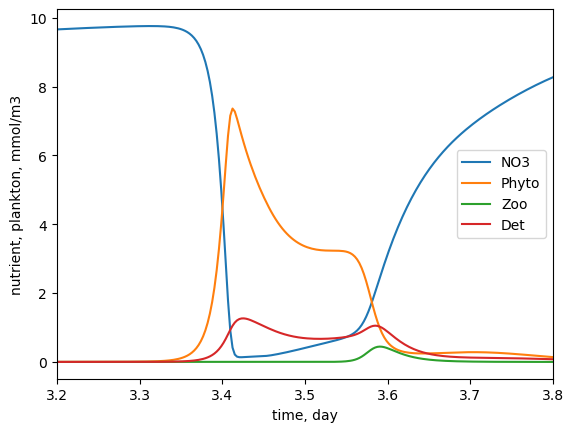

In [18]:
# plot the N15put
t_N15 = N15.t/365
vec_N15 = N15.y
N_N15 = vec_N15[0,:]
P_N15 = vec_N15[1,:]
Z_N15 = vec_N15[2,:]
D_N15 = vec_N15[3,:]
#
plt.plot(t_N15,N_N15,label='NO3')
plt.plot(t_N15,P_N15,label='Phyto')
plt.plot(t_N15,Z_N15,label='Zoo')
plt.plot(t_N15,D_N15,label='Det')
plt.legend()
plt.xlabel('time, day')
plt.ylabel('nutrient, plankton, mmol/m3')
plt.xlim(3.2,3.8)
plt.show()

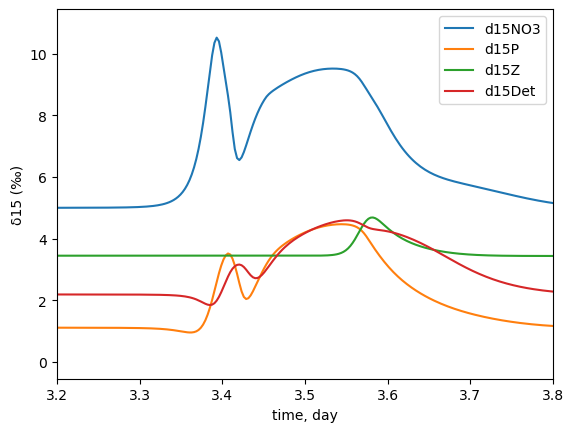

In [20]:
plt.plot(t_N15,delta15[4,:],label='d15NO3')
plt.plot(t_N15,delta15[5,:],label='d15P')
plt.plot(t_N15,delta15[6,:],label='d15Z')
plt.plot(t_N15,delta15[7,:],label='d15Det')
plt.legend()
plt.xlabel('time, day')
plt.ylabel('δ15 (‰)')
plt.xlim(3.2,3.8)
plt.show()

(3.0, 4.0)

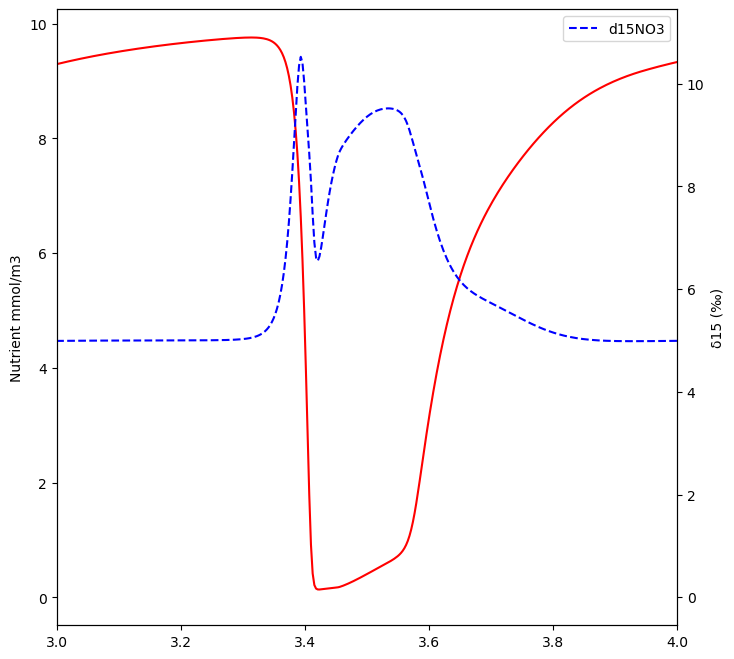

In [24]:
fig, ax1 = plt.subplots(figsize=(8, 8)) 
ax2 = ax1.twinx()

ax1.plot(t_N15, N_N15,color='r',label='NO3') 
#ax1.plot(t_N15, P_N15,color='g',label='NO3') 
ax2.plot(t_N15, delta15[4,:],'b--',label='d15NO3')
ax1.set_ylabel('Nutrient mmol/m3')
ax2.set_ylabel('δ15 (‰)')
ax2.legend()
plt.xlim(3,4)

In [ ]:
plt.plot(N)

In [11]:
### NPZD-A2, model NO3 and NH4 separately
def cal_N15(t,x,Vmax,K,Kp,a,g,lp,lz,ld,KI,Nth,zI,Wsink,c):
    nitro, ammo, phy, zoo, det, N15, A15, P15, Z15, D15 = x
    hml = h0+h1*(1+np.cos(2*np.pi/360*t))
    dhdt= -h1*(2*np.pi/360)*np.sin(2*np.pi/360*t)
    ent0=dhdt/hml
    ent=np.where(ent0>0,ent0,0) + c
    I=fPAR*(I0+I1*(1-np.cos(2*np.pi/360*t)))
    Iave=I*zI/hml
    F=(nitro/(nitro+K))/(nitro/(nitro+K)+ammo/(ammo+Kammo))
    dnitrodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*F -ent*(nitro-Nth) + nit*ammo 
    dammodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*(1-F) + ld*det + (a-b)*zoo*g*phy/Kp -ent*(ammo-ammoth) - nit*ammo
    dphydt = Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI) - zoo*g*phy/Kp - (lp+ent)*phy
    dzoodt = zoo*g*phy/Kp - (lz+ent)*zoo - (a-b)*zoo*g*phy/Kp - (1-a)*zoo*g*phy/Kp
    ddetdt = (1-a)*zoo*g*phy/Kp + lz*zoo + lp*phy - (ld+ent)*det -Wsink/hml*det
    d15nitrodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*F*N15*alpha(eps_uptakeN) - ent*(nitro*N15-Nth*Nth15) + nit*ammo*R(A15)*alpha(eps_nitri)
    d15ammodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*(1-F)*A15*alpha(eps_uptakeA) + ld*det*D15*alpha(eps_reminer) + (a-b)*zoo*g*phy/Kp*Z15*alpha(eps_excretion) - ent*(ammo*A15-ammoth*ammoth15) - nit*ammo*R(A15)*alpha(eps_nitri)
    d15phydt = Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*F*N15*alpha(eps_uptakeN) + Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*(1-F)*A15*alpha(eps_uptakeA) - zoo*g*phy/Kp*P15 - (lp+ent)*phy*P15
    d15zoodt = zoo*g*phy/Kp*P15 - (lz+ent)*zoo*Z15 - (a-b)*zoo*g*phy/Kp*Z15*alpha(eps_excretion) - (1-a)*zoo*g*phy/Kp*Z15*alpha(eps_egestion)
    d15detdt = (1-a)*zoo*g*phy/Kp*Z15*alpha(eps_egestion) + lz*zoo*Z15 + lp*phy*P15 - ld*det*D15*alpha(eps_reminer) -ent*det*D15 -Wsink/hml*det*D15
    out=np.array([dnitrodt,dammodt,dphydt,dzoodt,ddetdt,d15nitrodt,d15ammodt,d15phydt,d15zoodt,d15detdt])
    return out

def cal_N14(t,x,Vmax,K,Kp,a,g,lp,lz,ld,KI,Nth,zI,Wsink,c):
    nitro, ammo, phy, zoo, det, N14, A14, P14, Z14, D14 = x
    hml = h0+h1*(1+np.cos(2*np.pi/360*t))
    dhdt= -h1*(2*np.pi/360)*np.sin(2*np.pi/360*t)
    ent0=dhdt/hml
    ent=np.where(ent0>0,ent0,0) + c
    I=fPAR*(I0+I1*(1-np.cos(2*np.pi/360*t)))
    Iave=I*zI/hml
    F=(nitro/(nitro+K))/(nitro/(nitro+K)+ammo/(ammo+Kammo))
    dnitrodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*F -ent*(nitro-Nth) + nit*ammo 
    dammodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*(1-F) + ld*det + (a-b)*zoo*g*phy/Kp -ent*(ammo-ammoth) - nit*ammo
    dphydt = Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI) - zoo*g*phy/Kp - (lp+ent)*phy
    dzoodt = zoo*g*phy/Kp - (lz+ent)*zoo - (a-b)*zoo*g*phy/Kp - (1-a)*zoo*g*phy/Kp
    ddetdt = (1-a)*zoo*g*phy/Kp + lz*zoo + lp*phy - (ld+ent)*det -Wsink/hml*det
    d14nitrodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*F*N14 - ent*(nitro*N14-Nth*Nth14) + nit*ammo*R(A14)
    d14ammodt = -Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*(1-F)*A14 + ld*det*D14*alpha(eps_reminer) + (a-b)*zoo*g*phy/Kp*Z14  - ent*(ammo*A14-ammoth*ammoth14) - nit*ammo*R(A14)
    d14phydt = Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*F*N14 + Vmax*(nitro/(nitro+K)+ammo/(ammo+Kammo))*phy*Iave/(Iave+KI)*(1-F)*A14 - zoo*g*phy/Kp*P14 - (lp+ent)*phy*P14
    d14zoodt = zoo*g*phy/Kp*P14 - (lz+ent)*zoo*Z14 - (a-b)*zoo*g*phy/Kp*Z14 - (1-a)*zoo*g*phy/Kp*Z14
    d14detdt = (1-a)*zoo*g*phy/Kp*Z14 + lz*zoo*Z14 + lp*phy*P14 - ld*det*D14 -ent*det*D14 -Wsink/hml*det*D14
    out=np.array([dnitrodt,dammodt,dphydt,dzoodt,ddetdt,d14nitrodt,d14ammodt,d14phydt,d14zoodt,d14detdt])
    return out


In [13]:
Nth=10
ammoth=3.5
# set time range
trange = [0,365*5]
# set parameters
param=np.array([Vmax,K,Kp,a,g,lp,lz,ld,KI,Nth,zI,Wsink,c])
# set initial conditions
xinit = np.array([nuto,.001,phyo,zooo,deto,1,1,1,1,1])
# time step size
h = 1
N15 = model_run(trange,xinit,param,h,cal_N15)
N14 = model_run(trange,xinit,param,h,cal_N14)
delta15 = ((N15.y/(N14.y/0.00366))/0.00366-1)*1000 

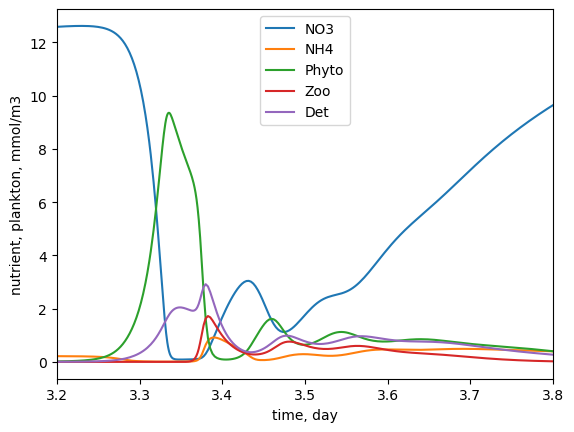

In [14]:
# plot the N15put
t_N15 = N15.t/365
vec_N15 = N15.y
N_N15 = vec_N15[0,:]
A_N15 = vec_N15[1,:]
P_N15 = vec_N15[2,:]
Z_N15 = vec_N15[3,:]
D_N15 = vec_N15[4,:]
#
plt.plot(t_N15,N_N15,label='NO3')
plt.plot(t_N15,A_N15,label='NH4')

plt.plot(t_N15,P_N15,label='Phyto')
plt.plot(t_N15,Z_N15,label='Zoo')
plt.plot(t_N15,D_N15,label='Det')
plt.legend()
plt.xlabel('time, day')
plt.ylabel('nutrient, plankton, mmol/m3')
plt.xlim(3.2,3.8)
plt.show()

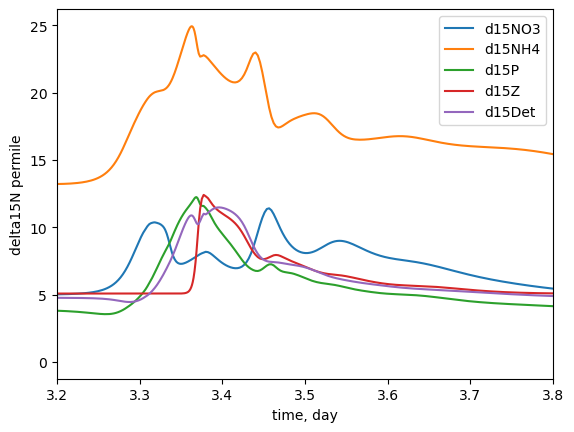

In [15]:
plt.plot(t_N15,delta15[5,:],label='d15NO3')
plt.plot(t_N15,delta15[6,:],label='d15NH4')
plt.plot(t_N15,delta15[7,:],label='d15P')
plt.plot(t_N15,delta15[8,:],label='d15Z')
plt.plot(t_N15,delta15[9,:],label='d15Det')
plt.legend()
plt.xlabel('time, day')
plt.ylabel('delta15N permile')
plt.xlim(3.2,3.8)
#plt.ylim(0,50)
plt.show()

(3.0, 4.0)

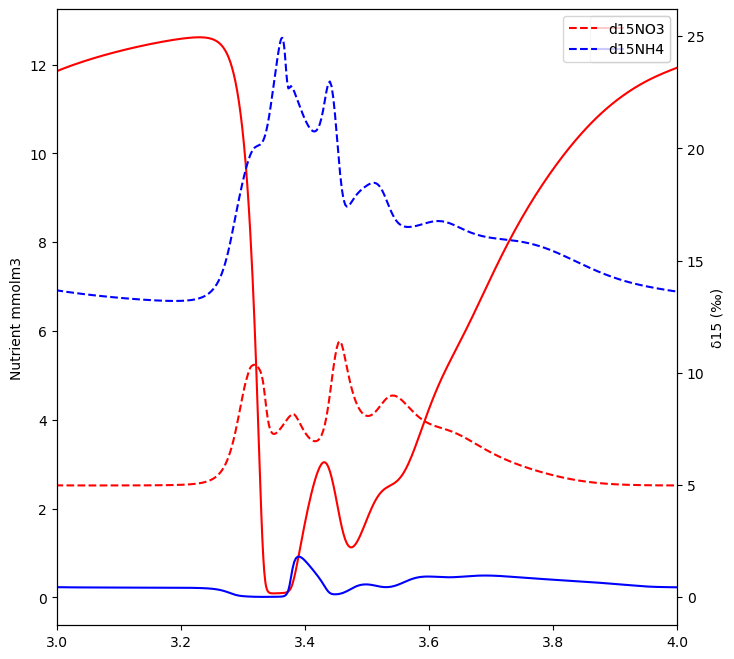

In [16]:
fig, ax1 = plt.subplots(figsize=(8, 8)) 
ax2 = ax1.twinx()

ax1.plot(t_N15, N_N15,color='r',label='NO3') 
ax1.plot(t_N15, A_N15,color='b',label='NH4')
ax2.plot(t_N15, delta15[5,:],'r--',label='d15NO3')
ax2.plot(t_N15, delta15[6,:],'b--',label='d15NH4')
ax1.set_ylabel('Nutrient mmol/m3')
ax2.set_ylabel('δ15 (‰)')
ax1.legend()
ax2.legend()
plt.xlim(3,4)